In [1]:
!pip install aicrowd-cli
%load_ext aicrowd.magic

     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 209 kB 22.7 MB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
     |████████████████████████████████| 170 kB 21.8 MB/s 
     |████████████████████████████████| 76 kB 5.8 MB/s 
     |████████████████████████████████| 54 kB 3.8 MB/s 
     |████████████████████████████████| 63 kB 2.5 MB/s 
     |████████████████████████████████| 51 kB 9.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requ

## How to use this notebook? 📝

<p style="text-align: center"><img src="https://gitlab.aicrowd.com/aicrowd/assets/-/raw/master/notebook/aicrowd_notebook_submission_flow.png?inline=false" alt="notebook overview" style="width: 650px;"/></p>

- **Update the config parameters**. You can define the common variables here

Variable | Description
--- | ---
`AICROWD_DATASET_PATH` | Path to the file containing test data (The data will be available at `/data/` on aridhia workspace). This should be an absolute path.
`AICROWD_OUTPUTS_PATH` | Path to write the output to.
`AICROWD_ASSETS_DIR` | In case your notebook needs additional files (like model weights, etc.,), you can add them to a directory and specify the path to the directory here (please specify relative path). The contents of this directory will be sent to AIcrowd for evaluation.
`AICROWD_API_KEY` | In order to submit your code to AIcrowd, you need to provide your account's API key. This key is available at https://www.aicrowd.com/participants/me

- **Installing packages**. Please use the [Install packages 🗃](#Install-packages-🗃) section to install the packages
- **Training your models**. All the code within the [Training phase ⚙️](#Training-phase-⚙️) section will be skipped during evaluation. **Please make sure to save your model weights in the assets directory and load them in the predictions phase section** 

## AIcrowd Runtime Configuration 🧷

Define configuration parameters. Please include any files needed for the notebook to run under `ASSETS_DIR`. We will copy the contents of this directory to your final submission file 🙂

The dataset is available under `/data` on the workspace.

In [2]:
import os

# Please use the absolute for the location of the dataset.
# Or you can use relative path with `os.getcwd() + "test_data/test.csv"`
AICROWD_DATASET_PATH = os.getenv("DATASET_PATH", os.getcwd()+"/data/test")
AICROWD_OUTPUTS_PATH = os.getenv("OUTPUTS_DIR", "")
AICROWD_ASSETS_DIR = os.getenv("ASSETS_DIR", "assets")

# Install packages 🗃

Installing PyTorch & some other libraries

In [3]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch pytorch-argus scikit-video natsort

# Installing Scikit Video & FFMPEG
!pip install scikit-video
!pip install ffmpeg
!apt-get install ffmpeg gstreamer1.0-libav vlc
!apt-get update -qq && sudo apt-get -y install \
  autoconf \
  automake \
  build-essential \
  cmake \
  git-core \
  libass-dev \
  libfreetype6-dev \
  libgnutls28-dev \
  libsdl2-dev \
  libtool \
  libva-dev \
  libvdpau-dev \
  libvorbis-dev \
  libxcb1-dev \
  libxcb-shm0-dev \
  libxcb-xfixes0-dev \
  meson \
  ninja-build \
  pkg-config \
  texinfo \
  wget \
  yasm \
  zlib1g-dev
!apt-get install ffmpeg libsm6  libxext6 -y
!pip install sk-video p-tqdm
!apt-get update
!apt-get install -y python3-opencv
!pip install --upgrade opencv
!pip install --upgrade torch torchvision
!pip install -U albumentations

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-mbbsvpzm
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-mbbsvpzm
     |████████████████████████████████| 2.3 MB 19.1 MB/s 
     |████████████████████████████████| 58 kB 9.0 MB/s 
     |████████████████████████████████| 376 kB 67.2 MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.2.0-py3-none-any.whl size=88675 sha256=ea18bc31ac7ddf484903b5d552708b36a1afe3409db95bd79051c6c209f8270f
  Stored in directory: /tmp/pip-ephem-wheel-cache-uidevtgs/wheels/fa/c5/a8/1e8af6cb04a0974db8a4a156ebd2fdd1d99ad2558d3fce49d4
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=fa37c6f8988ec2f4b12b47204c649d1458f47d70c0b35caffa3017d4510bf6fe
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel f

# Define preprocessing code 💻

The code that is common between the training and the prediction sections should be defined here. During evaluation, we completely skip the training section. Please make sure to add any common logic between the training and prediction sections here.

In [4]:
# Pytorch 
import torch
from torch import nn
import segmentation_models_pytorch as smp
import argus
from torch.utils.data import Dataset, DataLoader
import albumentations as albu
from albumentations.pytorch import ToTensorV2

# Reading Dataset, vis and miscellaneous
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm.notebook import tqdm
import cv2
from natsort import natsorted
from glob import glob
import skvideo.io
import torch.optim as optim
import torch.nn.functional as F

# Training phase ⚙️

You can define your training code here. This sections will be skipped during evaluation.

## Downloading Dataset

Hre we are downloading the challange dataset using AIcrowd CLI 

In [5]:
API_KEY = '' #Please enter your API Key from [https://www.aicrowd.com/participants/me]
!aicrowd login --api-key $API_KEY

API Key valid
Saved API Key successfully!


In [ ]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c iceberg-detection -o data

test.zip:   0%|          | 0.00/513k [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/116M [00:00<?, ?B/s]

In [ ]:
# Unzipping the files
!unzip data/train.zip -d data/train > /dev/null
!unzip data/test.zip -d data/test > /dev/null

### Dataloader

In [ ]:
class IcebergsSegmentationDataset(Dataset):
    
    def __init__(self, data_directory=None, transform=None):
        self.data_directory = data_directory
        self.transform = transform   
        if data_directory != None:
            self.image_videos_files = natsorted(glob(data_directory+"/image*"))
            self.segmentation_videos_files = natsorted(glob(data_directory+"/segmentation*"))
        self.img_list = list(zip(self.image_videos_files, self.segmentation_videos_files))
        
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_video = cv2.VideoCapture(self.img_list[idx][0]) 
        img_video.set(1, 15)

        ret, img = img_video.read()
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        seg_video = cv2.VideoCapture(self.img_list[idx][1])
        seg_video.set(1, 15)

        ret, mask = seg_video.read()

        img = np.array(img, dtype=np.float32)

        img = cv2.resize(img, (128, 128))
        mask = cv2.resize(mask, (128, 128))

        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(mask,127,255,cv2.THRESH_BINARY)

        if self.transform:
            augmentation = self.transform(image=img, mask=mask)
            img = augmentation['image'].float()
            mask = augmentation['mask'].float()
        return img, mask.unsqueeze(0) / 255

In [ ]:
def get_transforms(data=''):
    if data == 'train':
        return albu.Compose([
                             albu.RandomResizedCrop(128, 128, scale=(0.9, 1.0)),
                             albu.HorizontalFlip(),
                             albu.OpticalDistortion(p=0.4),
                             albu.GridDistortion(p=0.4),
                             albu.IAAPiecewiseAffine(p=0.3),
                             albu.RandomBrightnessContrast(p=0.3),
                             albu.RandomGamma(p=0.2),
                             ToTensorV2()
        ])
    elif data == 'valid':
        return albu.Compose([
                             ToTensorV2()
        ])

In [ ]:
# Creating the training dataset
train_dataset = IcebergsSegmentationDataset(data_directory="data/train", transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=40, num_workers=1, shuffle=True, drop_last=True)

In [ ]:
# Reading the image and corrosponding segmentation
image_batch, segmentation_batch = next(iter(train_loader))

image_batch.shape, segmentation_batch.shape

## Creating the Model

Here we will get setting up the model architecture, optimizer and loss.

In [ ]:
def get_UnetPlusPlus():
    model =  smp.UnetPlusPlus(
                 encoder_name='efficientnet-b4',
                 in_channels=1,
                 classes=1)
    return model

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

## Training the Model

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
model = get_UnetPlusPlus().to(device)

num_epochs = 40

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-3},
    {'params': model.encoder.parameters(), 'lr': 1e-3}
])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.15, patience=2, verbose=1)
diceloss = DiceLoss()

best_loss = np.inf
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    
    for data in train_loader:
        optimizer.zero_grad()
        img, mask = data
        img = img.to(device)
        mask = mask.to(device)
        outputs = model(img)
        loss = diceloss(outputs, mask)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    scheduler.step(train_loss)
    print(f"EPOCH: {epoch + 1}, train_loss: {train_loss}")

    if train_loss < best_loss:
        best_loss = train_loss
        torch.save(model, "model.pth")
        print(f"Save best loss: {best_loss}")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


EPOCH: 1, train_loss: 0.4505716562271118
Save best loss: 0.4505716562271118
EPOCH: 2, train_loss: 0.38774805784225463
Save best loss: 0.38774805784225463
EPOCH: 3, train_loss: 0.35419713616371157
Save best loss: 0.35419713616371157
EPOCH: 4, train_loss: 0.34091006755828857
Save best loss: 0.34091006755828857
EPOCH: 5, train_loss: 0.3360743772983551
Save best loss: 0.3360743772983551
EPOCH: 6, train_loss: 0.29750931859016416
Save best loss: 0.29750931859016416
EPOCH: 7, train_loss: 0.30851830005645753
EPOCH: 8, train_loss: 0.2806753468513489
Save best loss: 0.2806753468513489
EPOCH: 9, train_loss: 0.26583393454551696
Save best loss: 0.26583393454551696
EPOCH: 10, train_loss: 0.25857396602630617
Save best loss: 0.25857396602630617
EPOCH: 11, train_loss: 0.26158785820007324
EPOCH: 12, train_loss: 0.24680514693260192
Save best loss: 0.24680514693260192
EPOCH: 13, train_loss: 0.23202844619750976
Save best loss: 0.23202844619750976
EPOCH: 14, train_loss: 0.242428537607193
EPOCH: 15, train_lo

## Visualize Predictions

In [ ]:
predictions = model.predict(image_batch.to(device))
predictions.shape

torch.Size([40, 1, 128, 128])

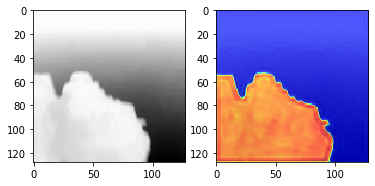

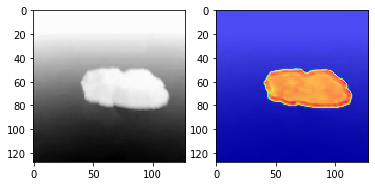

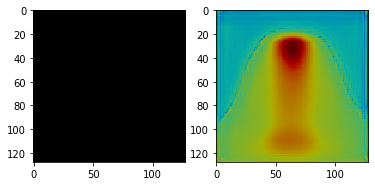

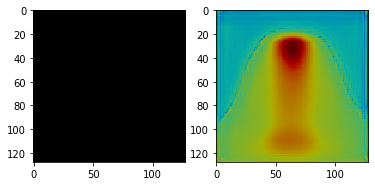

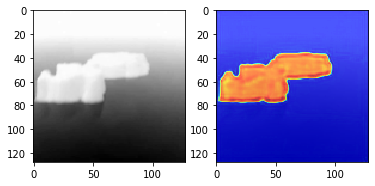

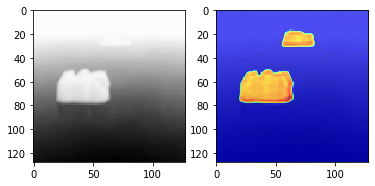

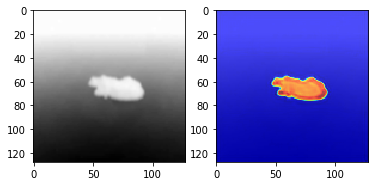

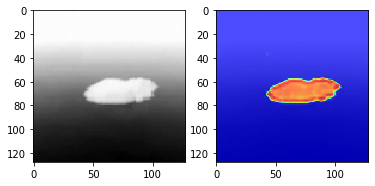

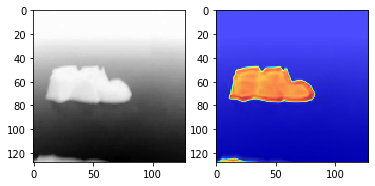

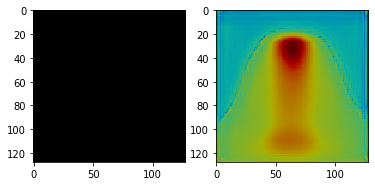

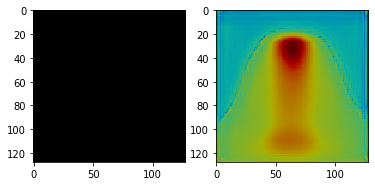

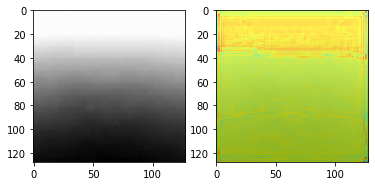

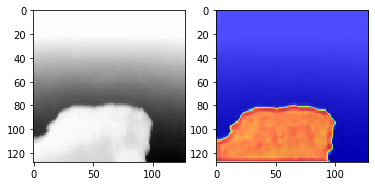

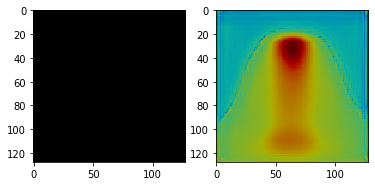

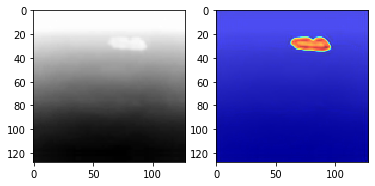

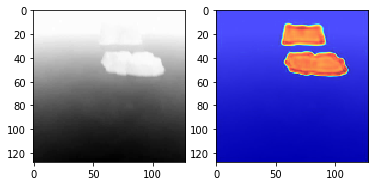

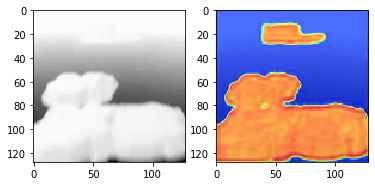

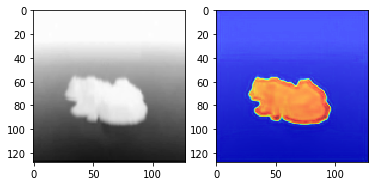

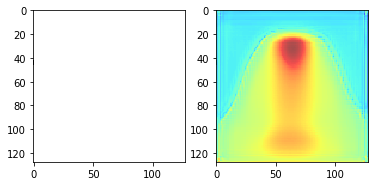

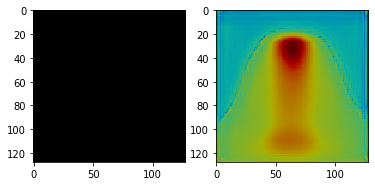

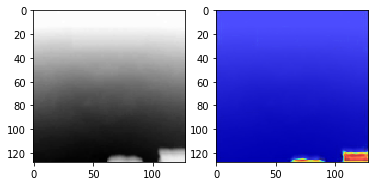

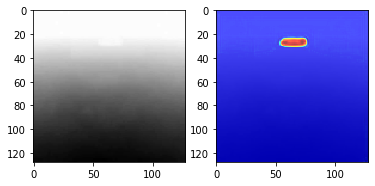

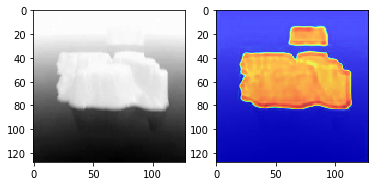

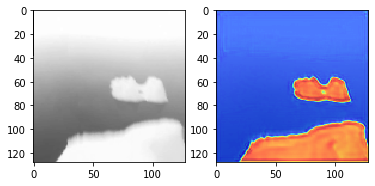

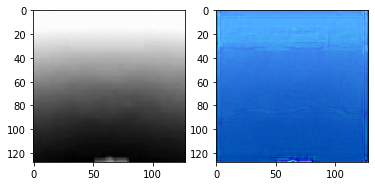

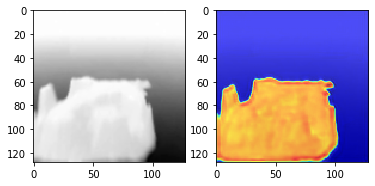

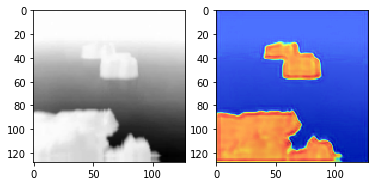

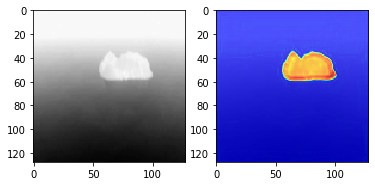

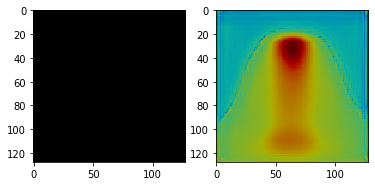

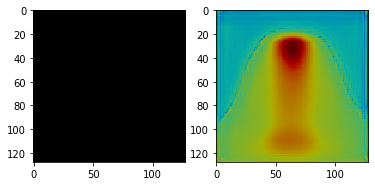

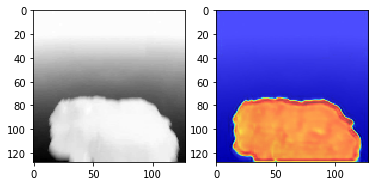

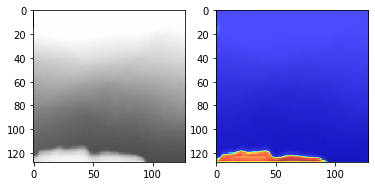

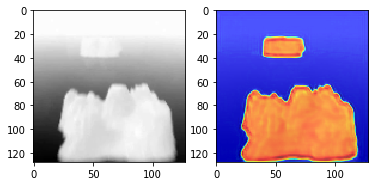

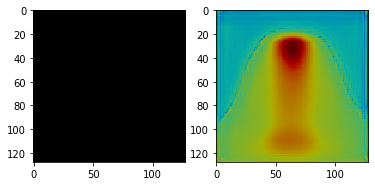

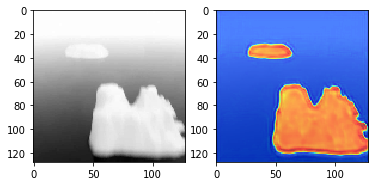

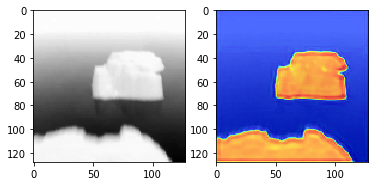

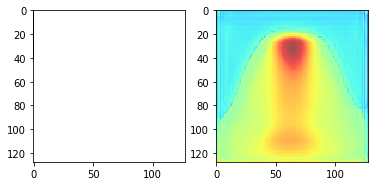

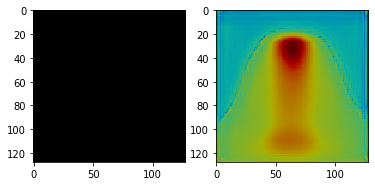

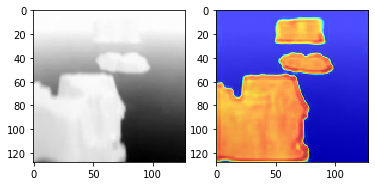

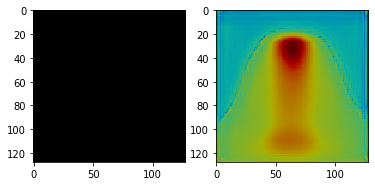

In [ ]:
# Going through each image and segmentation
for image, segmentation in zip(image_batch, predictions.cpu()):
    image = image.numpy()[0]/255
    
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(image, 'gray', interpolation='none')
    plt.subplot(1,2,2)
    plt.imshow(image, 'gray', interpolation='none')
    plt.imshow(segmentation[0], 'jet', interpolation='none', alpha=0.7)
    plt.show()

## Saving the Model

In [ ]:
!mkdir assets
torch.save(model, os.path.join("assets", "model.h5"))

# Prediction phase 🔎

Generating the features in test dataset. 

## Loading the Model

In [ ]:
device = torch.device("cpu")

In [ ]:
model = torch.load(os.path.join("assets", "model.h5"), map_location=torch.device('cpu'))
model

UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      1, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )


In [ ]:
# Test Dataloader Class
class IcebergsSegmentationTestDataset(Dataset):
    
    def __init__(self, data_directory=None, transform=None):
        
      self.data_directory = data_directory
      self.transform = transform      

      # If the image direcotry is valid      
      if data_directory != None:
        self.image_videos_files = natsorted(glob(os.path.join(data_directory, "image")+"*"))

      self.img_list = self.image_videos_files
        
    def __len__(self):
      
      # Number of test images * Number of frame 
      return len(self.img_list)*23

    def __getitem__(self, idx):
      
      # Reading the Video
      img_video = cv2.VideoCapture(self.img_list[idx//23]) 
      
      # Reading the specific frame of the video
      img_video.set(1, idx%23)

      ret, img = img_video.read()
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

      # Chaning the dtype
      img = np.array(img, dtype=np.float32)

      # Resizing the image
      img = cv2.resize(img, (128, 128))

      if self.transform:
          img = self.transform(image=img)['image']

      return img

In [ ]:
def get_transforms(data=''):
    if data == 'train':
        return albu.Compose([
                             albu.HorizontalFlip(),
                             albu.OpticalDistortion(p=0.2),
                             albu.GridDistortion(p=0.2),
                             albu.IAAPiecewiseAffine(p=0.2),
                             albu.HueSaturationValue(hue_shift_limit=9, sat_shift_limit=5, val_shift_limit=7, p=0.2),
                             albu.CLAHE(p=0.2),
                             albu.RandomBrightnessContrast(p=0.3),
                             albu.RandomGamma(p=0.15),
                             ToTensorV2()
        ])
    elif data == 'valid':
        return albu.Compose([
                             ToTensorV2()
        ])


test_dataset = IcebergsSegmentationTestDataset(data_directory=AICROWD_DATASET_PATH, transform=get_transforms(data='valid'))
test_loader = DataLoader(test_dataset, batch_size=23, num_workers=1, shuffle=False, drop_last=False)

# Reading the image and corrosponding segmentation
image_batch = next(iter(test_loader))
image_batch.shape

torch.Size([23, 1, 128, 128])

In [ ]:
# from google.colab.patches import cv2_imshow

In [ ]:
# Generating Predictions Function
def gen_predictions(test_loader, model, AICROWD_OUTPUTS_PATH):

  for batch_idx, image_batch in tqdm(enumerate(test_loader)):

    model = model.to("cpu")
    image_batch = image_batch.to("cpu")
    # for image in image_batch:
    #     img_np = image[0].numpy()
    #     cv2_imshow(img_np)

    predictions = model.predict(image_batch)

    writer = skvideo.io.FFmpegWriter(os.path.join(AICROWD_OUTPUTS_PATH,  f"segmentation_{batch_idx}.mp4"), outputdict={
                '-vcodec': 'libx264',  
                '-crf': '0',           
                '-preset':'veryslow'   
                })


    for seg in predictions:
      
      seg_np = seg[0].numpy()

      # Setting a threshold to get the segmentation in some parts 
      _, seg_np = cv2.threshold(seg_np,0.5,1,cv2.THRESH_BINARY)

      # Resizing the video
      seg_np = cv2.resize(seg_np*255, (512, 512))
      # cv2_imshow(seg_np)
      
      
      writer.writeFrame(seg_np.astype(np.uint8))

    writer.close()

## Generating the Predictions

In [ ]:
gen_predictions(test_loader, model, AICROWD_OUTPUTS_PATH)

0it [00:00, ?it/s]

# Submit to AIcrowd 🚀¶

> Don't be shy to ask question related to any errors you are getting or doubts in any part of this notebook in [discussion forum](https://www.aicrowd.com/challenges/ai-blitz-10/problems/icebergs-detection/discussion) or in [AIcrowd Discord server](https://discord.gg/T6uZSWBMSZ), AIcrew will be happy to help you :)

Also, wanna give us your valuable feedback for next blitz or wanna work with us creating blitz challanges ? Let us know! 

In [ ]:
!aicrowd -v notebook submit --assets-dir assets --challenge iceberg-detection --no-verify